### https://github.com/benibaeumle/Learning-Shapelets


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Pytho

              precision    recall  f1-score   support

           A       0.38      0.68      0.49      3724
           H       1.00      0.00      0.00      1190
           M       0.66      0.81      0.73      6501
           P       0.29      0.00      0.01      1468
           S       0.06      0.00      0.00      1202
           T       1.00      0.00      0.00       509
   Toilettes       1.00      0.00      0.00        44

    accuracy                           0.53     14638
   macro avg       0.63      0.21      0.18     14638
weighted avg       0.54      0.53      0.45     14638



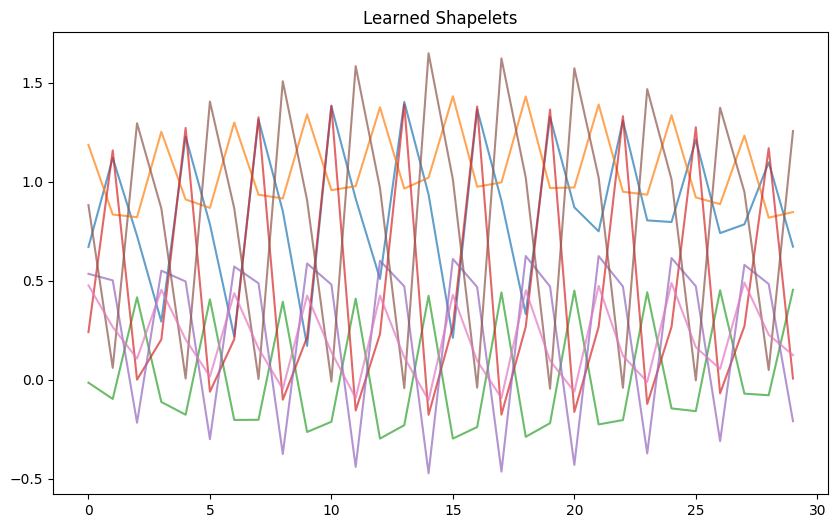

In [4]:
# Load data and preprocess it

def extract_segments(df, activity, window_size=100):
    """
    Extract time series segments from the dataset based on activity labels.
    
    Parameters:
    df (DataFrame): Accelerometer data.
    activity (DataFrame): Activity labels with start and end times.
    window_size (int): Size of the segments to extract.
    
    Returns:
    np.array: Segments of time series data.
    np.array: Corresponding activity labels.
    """
    segments, labels = [], []
    for _, row in activity.iterrows():
        start, end, label = row['debut'], row['fin'], row['activite']
        segment = df[(df['date_time'] >= start) & (df['date_time'] <= end)][['X', 'Y', 'Z']].values
        
        for i in range(0, len(segment) - window_size, window_size // 2):
            segments.append(segment[i:i + window_size])
            labels.append(label)
    
    return np.array(segments), np.array(labels)

# Load accelerometer data
df = pd.read_csv('../data/Marion.lnk/MG_D.csv')
df.columns = ['date_time', 'X', 'Y', 'Z']
df['date_time'] = pd.to_datetime(df['date_time'])

# Load activity annotations
activity = pd.read_csv('../data/activity_M.csv', sep=';', skipinitialspace=True)
activity.columns = activity.columns.str.strip()

# Convert days into actual dates
base_date = pd.to_datetime("2024-04-15")
activity['date'] = base_date + pd.to_timedelta(activity['jour'], unit='D')

# Clean and format activity timestamps
def clean_time(time_str):
    """
    Standardizes time format and handles missing values.
    """
    if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        return np.nan  
    time_str = time_str.strip().replace("h", ":")  
    if ":" not in time_str:
        return time_str + ":00"  
    elif time_str.count(":") == 1:
        return time_str + ":00"  
    return time_str

activity['debut'] = activity['debut'].astype(str).apply(clean_time)
activity['fin'] = activity['fin'].astype(str).apply(clean_time)
activity['debut'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['debut'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
activity['fin'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['fin'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
activity.drop(columns=['date'], inplace=True)

# Prepare data for Shapelet Learning
activity = activity  # Keep all activities
X, y = extract_segments(df, activity, window_size=100)
scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define shapelet parameters
min_shapelet_length = max(10, int(0.1 * X_train.shape[1]))
if X_train.shape[0] > 10 and X_train.shape[1] > min_shapelet_length:
    shapelet_sizes = grabocka_params_to_shapelet_size_dict(
        n_ts=X_train.shape[0], ts_sz=X_train.shape[1], 
        n_classes=len(np.unique(y_train)), l=0.1, r=1
    )
else:
    shapelet_sizes = {min_shapelet_length: 5}  # Default minimum value

# Define the Shapelet Learning model
shapelet_model = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                               optimizer="sgd",
                               weight_regularizer=0.01,
                               max_iter=500)

# Create a pipeline with shapelet transformation and classification
pipeline = Pipeline([
    ('shapelet_transform', shapelet_model),
    ('classifier', LogisticRegression())
])

# Train the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Generate a classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))

# Visualize the learned shapelets
plt.figure(figsize=(10, 6))
for shapelet in shapelet_model.shapelets_as_time_series_:
    plt.plot(shapelet.ravel(), alpha=0.7)
plt.title("Learned Shapelets")
plt.show()


/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Pytho

              precision    recall  f1-score   support

           A       0.37      0.65      0.47      3736
           H       0.00      0.00      0.00      1202
           M       0.65      0.80      0.72      6478
           P       1.00      0.00      0.00      1492
           S       0.18      0.01      0.02      1171
           T       1.00      0.00      0.00       513

    accuracy                           0.52     14592
   macro avg       0.53      0.24      0.20     14592
weighted avg       0.54      0.52      0.44     14592



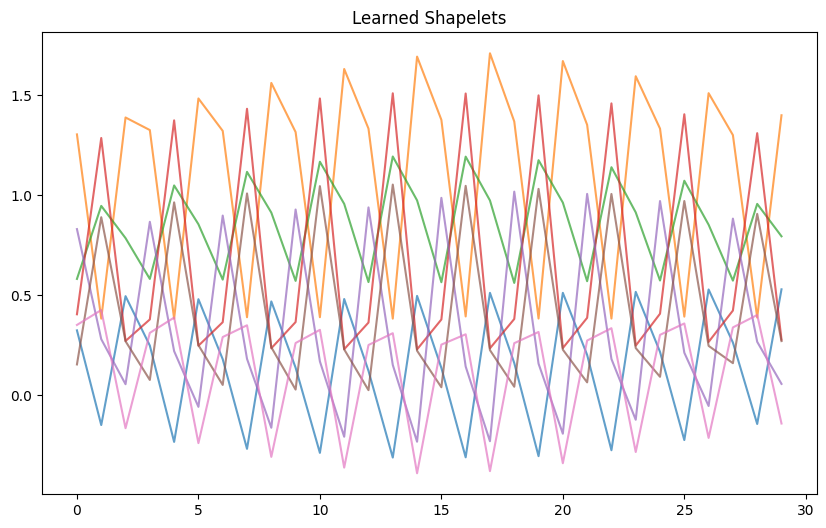

In [6]:
# Load data and preprocess it

def extract_segments(df, activity, window_size=100):
    """
    Extract time series segments from the dataset based on activity labels.
    
    Parameters:
    df (DataFrame): Accelerometer data.
    activity (DataFrame): Activity labels with start and end times.
    window_size (int): Size of the segments to extract.
    
    Returns:
    np.array: Segments of time series data.
    np.array: Corresponding activity labels.
    """
    segments, labels = [], []
    for _, row in activity.iterrows():
        start, end, label = row['debut'], row['fin'], row['activite']
        segment = df[(df['date_time'] >= start) & (df['date_time'] <= end)][['X', 'Y', 'Z']].values
        
        for i in range(0, len(segment) - window_size, window_size // 2):
            segments.append(segment[i:i + window_size])
            labels.append(label)
    
    return np.array(segments), np.array(labels)

# Load accelerometer data
df = pd.read_csv('../data/Marion.lnk/MG_D.csv')
df.columns = ['date_time', 'X', 'Y', 'Z']
df['date_time'] = pd.to_datetime(df['date_time'])

# Load activity annotations
activity = pd.read_csv('../data/activity_M.csv', sep=';', skipinitialspace=True)
activity.columns = activity.columns.str.strip()

# Convert days into actual dates
base_date = pd.to_datetime("2024-04-15")
activity['date'] = base_date + pd.to_timedelta(activity['jour'], unit='D')

# Clean and format activity timestamps
def clean_time(time_str):
    """
    Standardizes time format and handles missing values.
    """
    if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        return np.nan  
    time_str = time_str.strip().replace("h", ":")  
    if ":" not in time_str:
        return time_str + ":00"  
    elif time_str.count(":") == 1:
        return time_str + ":00"  
    return time_str

activity['debut'] = activity['debut'].astype(str).apply(clean_time)
activity['fin'] = activity['fin'].astype(str).apply(clean_time)
activity['debut'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['debut'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
activity['fin'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['fin'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
activity.drop(columns=['date'], inplace=True)

# Remove "Toilettes" activity
activity = activity[activity['activite'] != 'Toilettes']

# Prepare data for Shapelet Learning
X, y = extract_segments(df, activity, window_size=100)
scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define shapelet parameters
shapelet_sizes = grabocka_params_to_shapelet_size_dict(
    n_ts=X_train.shape[0], ts_sz=X_train.shape[1], 
    n_classes=len(np.unique(y_train)), l=0.1, r=1
)

# Define the Shapelet Learning model
shapelet_model = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                               optimizer="sgd",
                               weight_regularizer=0.01,
                               max_iter=500)

# Create a pipeline with shapelet transformation and classification
pipeline = Pipeline([
    ('shapelet_transform', shapelet_model),
    ('classifier', LogisticRegression())
])

# Train the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Generate a classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))

# Visualize the learned shapelets
plt.figure(figsize=(10, 6))
for shapelet in shapelet_model.shapelets_as_time_series_:
    plt.plot(shapelet.ravel(), alpha=0.7)
plt.title("Learned Shapelets")
plt.show()


/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a futu

              precision    recall  f1-score   support

           A       0.59      0.55      0.57      6535
           H       0.67      0.73      0.70      6467
           M       0.77      0.66      0.71      6466
           P       0.69      0.71      0.70      6494
           S       0.72      0.72      0.72      6499
           T       0.78      0.86      0.82      6586

    accuracy                           0.70     39047
   macro avg       0.70      0.70      0.70     39047
weighted avg       0.70      0.70      0.70     39047



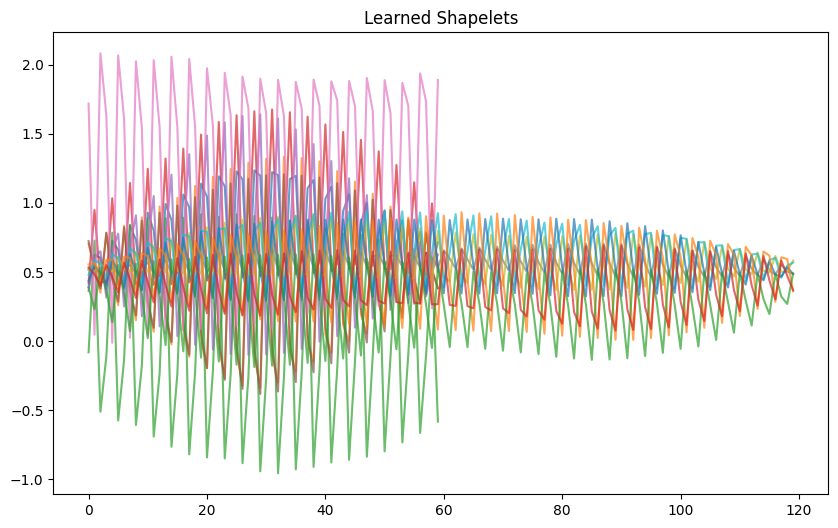

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Load data and preprocess it

def extract_segments(df, activity, window_size=100):
    """
    Extract time series segments from the dataset based on activity labels.
    
    Parameters:
    df (DataFrame): Accelerometer data.
    activity (DataFrame): Activity labels with start and end times.
    window_size (int): Size of the segments to extract.
    
    Returns:
    np.array: Segments of time series data.
    np.array: Corresponding activity labels.
    """
    segments, labels = [], []
    for _, row in activity.iterrows():
        start, end, label = row['debut'], row['fin'], row['activite']
        segment = df[(df['date_time'] >= start) & (df['date_time'] <= end)][['X', 'Y', 'Z']].values
        
        for i in range(0, len(segment) - window_size, window_size // 2):
            segments.append(segment[i:i + window_size])
            labels.append(label)
    
    return np.array(segments), np.array(labels)

# Load accelerometer data
#df = pd.read_csv('../data/Marion.lnk/MG_D.csv')
#df.columns = ['date_time', 'X', 'Y', 'Z']
#df['date_time'] = pd.to_datetime(df['date_time'])

# Load activity annotations
#activity = pd.read_csv('../data/activity_M.csv', sep=';', skipinitialspace=True)
#activity.columns = activity.columns.str.strip()

# Convert days into actual dates
#base_date = pd.to_datetime("2024-04-15")
#activity['date'] = base_date + pd.to_timedelta(activity['jour'], unit='D')

# Clean and format activity timestamps
#def clean_time(time_str):
    """
    Standardizes time format and handles missing values.
    """
    #if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        #return np.nan  
    #time_str = time_str.strip().replace("h", ":")  
    #if ":" not in time_str:
     #   return time_str + ":00"  
    #elif time_str.count(":") == 1:
    #    return time_str + ":00"  
    #return time_str

#activity['debut'] = activity['debut'].astype(str).apply(clean_time)
#activity['fin'] = activity['fin'].astype(str).apply(clean_time)
#activity['debut'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['debut'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
#activity['fin'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['fin'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
#activity.drop(columns=['date'], inplace=True)

# Remove "Toilettes" activity
activity = activity[activity['activite'] != 'Toilettes']

# Prepare data for Shapelet Learning
X, y = extract_segments(df, activity, window_size=100)
scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled.reshape(X_scaled.shape[0], -1), y_encoded)
X_resampled = X_resampled.reshape(-1, X_scaled.shape[1], X_scaled.shape[2])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define shapelet parameters
shapelet_sizes = grabocka_params_to_shapelet_size_dict(
    n_ts=X_train.shape[0], ts_sz=X_train.shape[1], 
    n_classes=len(np.unique(y_train)), l=0.2, r=2  # Increase shapelet size for better feature extraction
)

# Define the Shapelet Learning model
shapelet_model = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                               optimizer="sgd",
                               weight_regularizer=0.01,
                               max_iter=1000)  # Increase max_iter for better convergence

# Create a pipeline with shapelet transformation and classification
pipeline = Pipeline([
    ('shapelet_transform', shapelet_model),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Use Random Forest instead of Logistic Regression
])

# Train the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Generate a classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=1))

# Visualize the learned shapelets
plt.figure(figsize=(10, 6))
for shapelet in shapelet_model.shapelets_as_time_series_:
    plt.plot(shapelet.ravel(), alpha=0.7)
plt.title("Learned Shapelets")
plt.show()


/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a futu

Epoch 1/20


/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.2982 - loss: 1.6204 - val_accuracy: 0.3471 - val_loss: 1.5500
Epoch 2/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3487 - loss: 1.5556 - val_accuracy: 0.3566 - val_loss: 1.5420
Epoch 3/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3578 - loss: 1.5407 - val_accuracy: 0.3676 - val_loss: 1.5230
Epoch 4/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3666 - loss: 1.5316 - val_accuracy: 0.3731 - val_loss: 1.5148
Epoch 5/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3726 - loss: 1.5194 - val_accuracy: 0.3837 - val_loss: 1.4965
Epoch 6/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.3811 - loss: 1.5046 - val_accuracy: 0.3854 - val_loss: 1.4887
Epoch 7/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3853 - loss: 1.5010 - val_accuracy: 0.3905 - val_loss: 1.4845
Epoch 8/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3870 - loss: 1.4996 - val_accurac

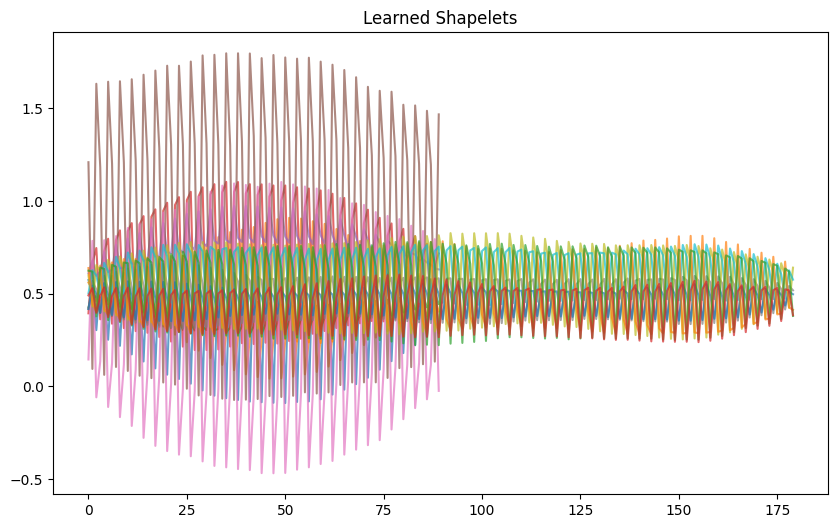

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from imblearn.over_sampling import SMOTE

# Function to extract time series segments from the dataset based on activity labels
def extract_segments(df, activity, window_size=150):
    """
    Extract time series segments from the dataset based on activity labels.
    
    Parameters:
    df (DataFrame): Accelerometer data.
    activity (DataFrame): Activity labels with start and end times.
    window_size (int): Size of the segments to extract.
    
    Returns:
    np.array: Segments of time series data.
    np.array: Corresponding activity labels.
    """
    segments, labels = [], []
    for _, row in activity.iterrows():
        start, end, label = row['debut'], row['fin'], row['activite']
        segment = df[(df['date_time'] >= start) & (df['date_time'] <= end)][['X', 'Y', 'Z']].values
        
        for i in range(0, len(segment) - window_size, window_size // 2):
            segments.append(segment[i:i + window_size])
            labels.append(label)
    
    return np.array(segments), np.array(labels)

# Load accelerometer data
df = pd.read_csv('../data/Marion.lnk/MG_D.csv')
df.columns = ['date_time', 'X', 'Y', 'Z']
df['date_time'] = pd.to_datetime(df['date_time'])

# Load activity annotations
activity = pd.read_csv('../data/activity_M.csv', sep=';', skipinitialspace=True)
activity.columns = activity.columns.str.strip()

# Convert days into actual dates
base_date = pd.to_datetime("2024-04-15")
activity['date'] = base_date + pd.to_timedelta(activity['jour'], unit='D')

# Function to clean and format time strings
def clean_time(time_str):
    """
    Standardizes time format and handles missing values.
    """
    if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        return np.nan  
    time_str = time_str.strip().replace("h", ":")  
    if ":" not in time_str:
        return time_str + ":00"  
    elif time_str.count(":") == 1:
        return time_str + ":00"  
    return time_str

activity['debut'] = activity['debut'].astype(str).apply(clean_time)
activity['fin'] = activity['fin'].astype(str).apply(clean_time)
activity['debut'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['debut'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
activity['fin'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['fin'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
activity.drop(columns=['date'], inplace=True)

# Remove "Toilettes" activity
activity = activity[activity['activite'] != 'Toilettes']

# Prepare data for Shapelet Learning
X, y = extract_segments(df, activity, window_size=150)
scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled.reshape(X_scaled.shape[0], -1), y_encoded)
X_resampled = X_resampled.reshape(-1, X_scaled.shape[1], X_scaled.shape[2])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define shapelet parameters
shapelet_sizes = grabocka_params_to_shapelet_size_dict(
    n_ts=X_train.shape[0], ts_sz=X_train.shape[1], 
    n_classes=len(np.unique(y_train)), l=0.2, r=2
)

# Define the Shapelet Learning model
shapelet_model = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                               optimizer="sgd",
                               weight_regularizer=0.01,
                               max_iter=1000)

# Train Shapelet Model
pipeline = Pipeline([
    ('shapelet_transform', shapelet_model),
])
pipeline.fit(X_train, y_train)

# Feature extraction using Shapelets
X_train_shapelet = pipeline.transform(X_train)
X_test_shapelet = pipeline.transform(X_test)

# Define a CNN Model for classification
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_shapelet.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the CNN classifier
model.fit(X_train_shapelet, y_train, epochs=20, batch_size=32, validation_data=(X_test_shapelet, y_test))

# Predict and evaluate
y_pred = model.predict(X_test_shapelet)
y_pred_labels = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_, zero_division=1))

# Visualize the learned shapelets
plt.figure(figsize=(10, 6))
for shapelet in shapelet_model.shapelets_as_time_series_:
    plt.plot(shapelet.ravel(), alpha=0.7)
plt.title("Learned Shapelets")
plt.show()

/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a futu

Random Forest Classification Report:
              precision    recall  f1-score   support

           A       0.59      0.58      0.58      4386
           H       0.69      0.72      0.70      4412
           M       0.75      0.62      0.68      4375
           P       0.69      0.71      0.70      4314
           S       0.72      0.70      0.71      4330
           T       0.74      0.84      0.78      4213

    accuracy                           0.69     26030
   macro avg       0.69      0.69      0.69     26030
weighted avg       0.69      0.69      0.69     26030

Epoch 1/20


/Users/leoolivier/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3017 - loss: 1.6173 - val_accuracy: 0.3496 - val_loss: 1.5396
Epoch 2/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3555 - loss: 1.5425 - val_accuracy: 0.3689 - val_loss: 1.5171
Epoch 3/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3700 - loss: 1.5230 - val_accuracy: 0.3864 - val_loss: 1.5014
Epoch 4/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3756 - loss: 1.5165 - val_accuracy: 0.3915 - val_loss: 1.4927
Epoch 5/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3924 - loss: 1.4939 - val_accuracy: 0.3992 - val_loss: 1.4732
Epoch 6/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.3922 - loss: 1.4875 - val_accuracy: 0.4027 - val_loss: 1.4702
Epoch 7/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4004 - loss: 1.4764 - val_accuracy: 0.3987 - val_loss: 1.4779
Epoch 8/20
3254/3254 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.4032 - loss: 1.4713 - val_accurac

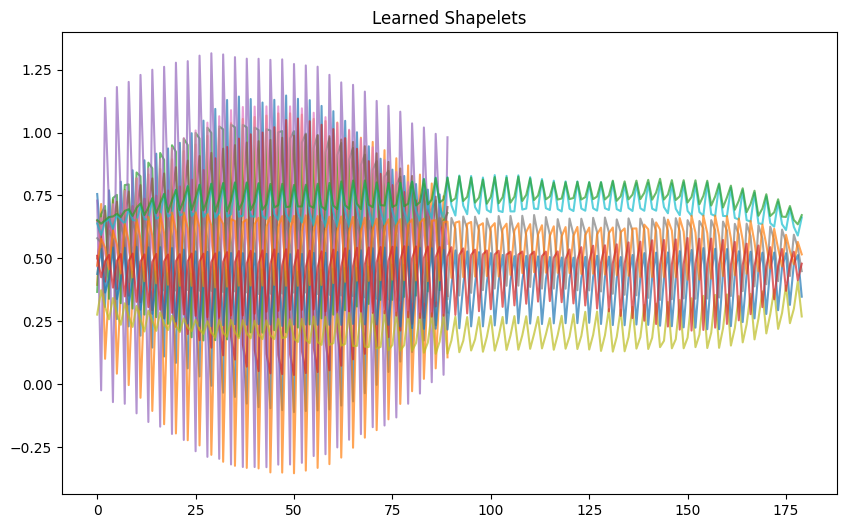

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Dropout, MaxPooling1D
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Step 1: Function to extract segments from time-series data
def extract_segments(df, activity, window_size=150):
    """
    Extract time series segments from accelerometer data using labeled activity time ranges.
    
    Parameters:
    - df (DataFrame): Accelerometer data with timestamps and X, Y, Z values.
    - activity (DataFrame): Activity annotations (start, end times).
    - window_size (int): Length of the segment window.

    Returns:
    - np.array: Extracted time series segments.
    - np.array: Corresponding activity labels.
    """
    segments, labels = [], []
    for _, row in activity.iterrows():
        start, end, label = row['debut'], row['fin'], row['activite']
        segment = df[(df['date_time'] >= start) & (df['date_time'] <= end)][['X', 'Y', 'Z']].values
        
        for i in range(0, len(segment) - window_size, window_size // 2):
            segments.append(segment[i:i + window_size])
            labels.append(label)
    
    return np.array(segments), np.array(labels)

# Step 2: Load accelerometer data
df = pd.read_csv('../data/Marion.lnk/MG_D.csv')
df.columns = ['date_time', 'X', 'Y', 'Z']
df['date_time'] = pd.to_datetime(df['date_time'])

# Step 3: Load activity annotations
activity = pd.read_csv('../data/activity_M.csv', sep=';', skipinitialspace=True)
activity.columns = activity.columns.str.strip()

# Convert days into actual dates
base_date = pd.to_datetime("2024-04-15")
activity['date'] = base_date + pd.to_timedelta(activity['jour'], unit='D')

# Step 4: Clean and format activity timestamps
def clean_time(time_str):
    """
    Standardizes time format and handles missing values.
    """
    if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        return np.nan  
    time_str = time_str.strip().replace("h", ":")  
    if ":" not in time_str:
        return time_str + ":00"  
    elif time_str.count(":") == 1:
        return time_str + ":00"  
    return time_str

activity['debut'] = activity['debut'].astype(str).apply(clean_time)
activity['fin'] = activity['fin'].astype(str).apply(clean_time)
activity['debut'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['debut'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
activity['fin'] = pd.to_datetime(activity['date'].astype(str) + " " + activity['fin'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
activity.drop(columns=['date'], inplace=True)

# Remove "Toilettes" activity
activity = activity[activity['activite'] != 'Toilettes']

# Step 5: Prepare data for Shapelet Learning
X, y = extract_segments(df, activity, window_size=150)
scaler = TimeSeriesScalerMinMax()
X_scaled = scaler.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 6: Apply SMOTE to balance dataset (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled.reshape(X_scaled.shape[0], -1), y_encoded)
X_resampled = X_resampled.reshape(-1, X_scaled.shape[1], X_scaled.shape[2])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 7: Define Shapelet Parameters
shapelet_sizes = grabocka_params_to_shapelet_size_dict(
    n_ts=X_train.shape[0], ts_sz=X_train.shape[1], 
    n_classes=len(np.unique(y_train)), l=0.2, r=2
)

# Step 8: Shapelet Learning Model
shapelet_model = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                               optimizer="sgd",
                               weight_regularizer=0.01,
                               max_iter=1000)

# Train Shapelet Model
pipeline = Pipeline([
    ('shapelet_transform', shapelet_model),
])
pipeline.fit(X_train, y_train)

# Feature extraction using Shapelets
X_train_shapelet = pipeline.transform(X_train)
X_test_shapelet = pipeline.transform(X_test)

# Step 9: Flatten Data for Random Forest
X_train_flat = X_train_shapelet.reshape(X_train_shapelet.shape[0], -1)
X_test_flat = X_test_shapelet.reshape(X_test_shapelet.shape[0], -1)

# Step 10: Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)
y_pred_rf = rf_model.predict(X_test_flat)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_, zero_division=1))

# Step 11: Define CNN Model for classification
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train_shapelet.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile CNN model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN Classifier
model.fit(X_train_shapelet, y_train, epochs=20, batch_size=32, validation_data=(X_test_shapelet, y_test))

# Step 12: Evaluate CNN Model
y_pred_cnn = model.predict(X_test_shapelet)
y_pred_labels_cnn = np.argmax(y_pred_cnn, axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_labels_cnn, target_names=label_encoder.classes_, zero_division=1))

# Step 13: Visualize the learned shapelets
plt.figure(figsize=(10, 6))
for shapelet in shapelet_model.shapelets_as_time_series_:
    plt.plot(shapelet.ravel(), alpha=0.7)
plt.title("Learned Shapelets")
plt.show()

